# CNN for MNIST image classification in PyTorch

Markus Enzweiler, markus.enzweiler@hs-esslingen.de

This is a demo used in a Computer Vision & Machine Learning lecture. Feel free to use and contribute.

We build and train a small CNN to classify MNIST digits (https://en.wikipedia.org/wiki/MNIST_database).



See https://pytorch.org/docs/stable/nn.html and in particular:
- https://pytorch.org/docs/stable/generated/torch.nn.Module.html  
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html 
- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

## Setup

Adapt `packagePath` to point to the directory containing this notebeook.

In [17]:
# Notebook id
nb_id = "cnn/mnist/torch"

# Imports
import sys
import os

In [18]:
# Package Path (folder of this notebook)

#####################
# Local environment #
#####################

package_path = "./"


#########
# Colab #
#########


def check_for_colab():
    try:
        import google.colab

        return True
    except ImportError:
        return False


# running on Colab?
on_colab = check_for_colab()

if on_colab:
    # assume this notebook is run from Google Drive and the whole
    # cv-ml-lecture-notebooks repo has been setup via setupOnColab.ipynb

    # Google Drive mount point
    gdrive_mnt = "/content/drive"

    ##########################################################################
    # Ensure that this is the same as gdrive_repo_root in setupOnColab.ipynb #
    ##########################################################################
    # Path on Google Drive to the cv-ml-lecture-notebooks repo
    gdrive_repo_root = f"{gdrive_mnt}/MyDrive/cv-ml-lecture-notebooks"

    # mount drive
    from google.colab import drive

    drive.mount(gdrive_mnt, force_remount=True)

    # set package path
    package_path = f"{gdrive_repo_root}/{nb_id}"

# check whether package path exists
if not os.path.isdir(package_path):
    raise FileNotFoundError(f"Package path does not exist: {package_path}")

print(f"Package path: {package_path}")

Package path: ./


In [19]:
# Additional imports

# Repository Root
repo_root = os.path.abspath(os.path.join(package_path, "..", "..", ".."))
# Add the repository root to the system path
if repo_root not in sys.path:
    sys.path.append(repo_root)


# Package Imports
from nbutils import requirements as nb_reqs
from nbutils import colab as nb_colab
from nbutils import git as nb_git
from nbutils import exec as nb_exec
from nbutils import data as nb_data

In [20]:
# Install requirements in the current Jupyter kernel
req_file = os.path.join(package_path, "requirements.txt")
nb_reqs.pip_install_reqs(req_file, on_colab)

['/Users/menzweil/Development/miniforge3/envs/mlx-pytorch-2024-01/bin/python', '-m', 'pip', 'install', '-r', './requirements.txt']


In [21]:
# Now we should be able to import the additional packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42);

Automatically select a good (GPU) device

In [22]:
# Check the devices that we have available and prefer CUDA over MPS and CPU
def autoselectDevice(verbose=0):
    # default: CPU
    device = torch.device("cpu")

    if torch.cuda.is_available():
        # CUDA
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # MPS (acceleration on Apple silicon M1 / M2 chips)
        device = torch.device("mps")

    if verbose:
        print("Using device:", device)

    # Additional Info when using cuda
    if verbose and device.type == "cuda":
        print(torch.cuda.get_device_name(0))

    return device


device = autoselectDevice(verbose=1)

Using device: mps


## Load the MNIST training and test data

In [23]:
# Load the MNIST dataset using torchvision
from torchvision import datasets, transforms

# Define a transform to normalize the pixel data to 0-1 range
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_set = datasets.MNIST("./data", download=True, train=True, transform=transform)
test_set = datasets.MNIST("./data", download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

## Visualize some samples and class labels

MNIST images have size 28x28


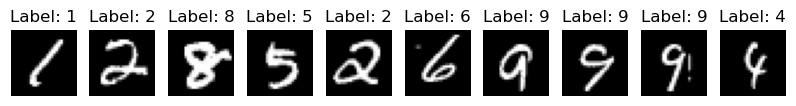

In [24]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

(data, target) = next(iter(train_loader))

# extract image size (height and width)
image_height = data.size(2)
image_width = data.size(3)
image_size = (image_height, image_width)

print(f"MNIST images have size {image_height}x{image_width}")

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(data[i, :, :, :].numpy().reshape(image_size), cmap="gray")
    plt.title("Label: " + str(target[i].item()))

# Define the Convolutional Neural Network (CNN)

## CNN class

In [25]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(
            1, 32, kernel_size=5, padding="same"
        )  # 5x5 kernels, 32 output channels
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=5, padding="same"
        )  # 5x5 kernels, 64 output channels
        self.pool = nn.MaxPool2d(2)
        self.classifier = nn.Linear(64 * 7 * 7, 10)

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        # input tensor shape: (batch_size, 1, 28, 28)
        # output tensor shape: (batch_size, 32, 28, 28)
        x = F.relu(self.conv1(x))

        # input tensor shape: (batch_size, 32, 28, 28)
        # output tensor shape: (batch_size, 32, 14, 14)
        x = self.pool(x)

        # input tensor shape: (batch_size, 32, 14, 14)
        # output tensor shape: (batch_size, 64, 14, 14)
        x = F.relu(self.conv2(x))

        # input tensor shape: (batch_size, 64, 14, 14)
        # output tensor shape: (batch_size, 64, 7, 7)
        x = self.pool(x)

        # input tensor shape: (batch_size, 64, 7, 7)
        # output tensor shape: (batch_size, 64 * 7 * 7)
        x = torch.flatten(x, 1)

        # "softmax" activation will be automatically applied in the cross entropy loss below,
        # see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        x = self.classifier(x)
        return x

# Training with gradient descent

## Training and testing functions

In [26]:
# Compute accuracy
def compute_accuracy(outputs, labels):
    # find predicted labels (the output neuron index with the highest output value)
    _, predicted_labels = torch.max(outputs, 1)
    return torch.sum(predicted_labels == labels)


# Training function
def train(model, train_loader, optimizer, loss_fn, num_epochs):
    # push the model to the device
    model.to(device)

    # Loop over epochs
    for epoch in range(num_epochs):
        # number of training samples in total
        num_train_samples = len(train_loader.dataset)

        # number of batches
        num_batches = len(train_loader)

        # reset accumulated loss and accuracy
        acc_loss = 0.0
        num_correct = 0.0

        # loop over data samples in batches
        for data in train_loader:
            # training sample and label
            x, y = data[0].to(device), data[1].to(device)

            # forward pass
            y_hat = model(x)

            # backward pass
            loss = loss_fn(y_hat, y)
            loss.backward()

            # accumulate loss
            acc_loss += loss

            # Update weights and bias
            optimizer.step()
            optimizer.zero_grad()

            # compute current accuracy and accumulate
            num_correct += compute_accuracy(y_hat, y)

        # average loss and accuracy per epoch
        avg_loss = acc_loss / num_batches
        accuracy = num_correct / num_train_samples

        # Print accumulated average loss per epoch
        print(
            f"Epoch {epoch:5d}: loss = {avg_loss:.5f}, accuracy on training set = {100 * accuracy:.2f}%"
        )

In [27]:
# Testing function


def test(model, test_loader):
    # test the model on all data points
    print("Testing ...")

    num_correct = 0
    test_size = len(test_loader.dataset)

    # push the model to the device
    model.to(device)

    for data in test_loader:
        x, y = data[0].to(device), data[1].to(device)
        prediction = model(x)

        # compute and accumulate accuracy
        num_correct += compute_accuracy(prediction, y)

    # Print accuracy
    print(f"Accuracy: {num_correct}/{test_size} = {100 * num_correct/test_size:.2f}%")

## Train and test the MLP

In [28]:
# Train the MLP model

# The model to train
model = CNN()

# Hyperparameters
num_epochs = 5
eta = 1e-4

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

# We use cross-entropy loss for classification problems
loss_fn = nn.CrossEntropyLoss()

# Train the model
train(model, train_loader, optimizer, loss_fn, num_epochs)

Epoch     0: loss = 0.49770, accuracy on training set = 86.71%
Epoch     1: loss = 0.13939, accuracy on training set = 95.89%
Epoch     2: loss = 0.09633, accuracy on training set = 97.17%
Epoch     3: loss = 0.07631, accuracy on training set = 97.77%
Epoch     4: loss = 0.06429, accuracy on training set = 98.11%


In [29]:
# Test the model
test(model, test_loader)

Testing ...
Accuracy: 9835/10000 = 98.35%


Run and visualize some predictions on the test set

In [30]:
test_iter = iter(test_loader)

Execute the following cell multiple times to see some more predictions

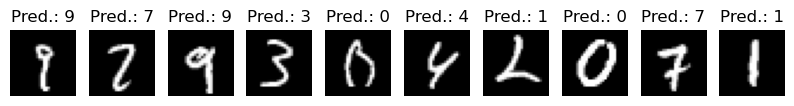

In [36]:
# run some predictions on the test set

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

# get next test data
(data, target) = next(test_iter)
data, target = data.to(device), target.to(device)

# forward pass
predictions = model(data)
# find predicted labels (the output neuron index with the highest output value)
_, predicted_labels = torch.max(predictions, 1)

# extract image size (height and width)
image_height = data.size(2)
image_width = data.size(3)
image_size = (image_height, image_width)

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(data[i, :, :, :].cpu().numpy().reshape(image_size), cmap="gray")
    plt.title("Pred.: " + str(predicted_labels[i].item()))